<a href="https://colab.research.google.com/github/YasirHabib/tensorflow/blob/master/cats_dogs_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#print(tf.__version__)                1.14.0

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### DATA LOADING

In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
#print(_URL)                          https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', _URL, extract = True)
#print(zip_dir)                       /root/.keras/datasets/cats_and_dogs_filtered.zip

In [91]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [0]:
base_dir = os.path.join(zip_dir_base, 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Understanding our data

In [93]:
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))

num_cats_validation = len(os.listdir(validation_cats_dir))
num_dogs_validation = len(os.listdir(validation_dogs_dir))

total_train = num_cats_train + num_dogs_train
total_validation = num_cats_validation + num_dogs_validation

print('total training cat images:', num_cats_train)
print('total training dog images:', num_dogs_train)

print('total validation cat images:', num_cats_validation)
print('total validation dog images:', num_dogs_validation)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_validation)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### Setting Model Parameters

In [0]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

### Data Preparation

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [0]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code

In [96]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.

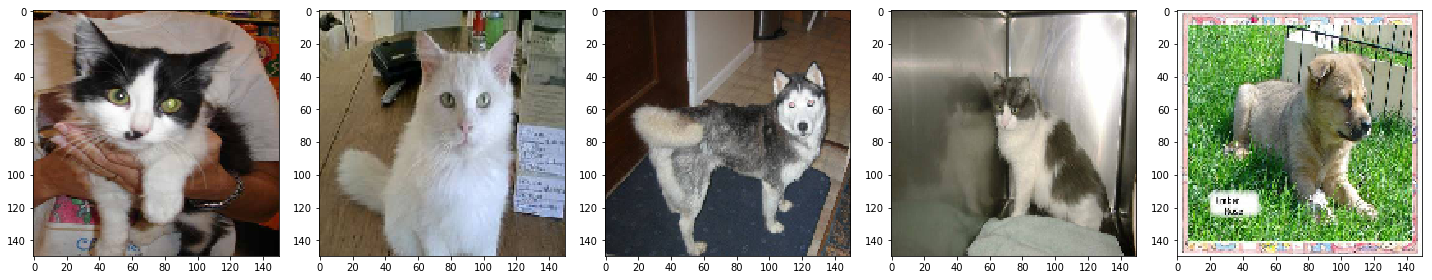

In [97]:
sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])       # Plot images 0-4

# Model Creation

### Define the model

In [0]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),    # if padding is not specified, then default is valid mode
    MaxPooling2D(pool_size=(2,2), strides=2),                         # if strides is not specified, then default is 2
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

### Compile the model

In [0]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

### Model Summary

In [100]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)      

### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [101]:
EPOCHS = 100
r = model.fit_generator(
    train_data_gen,
    steps_per_epoch = int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs = EPOCHS,
    validation_data = val_data_gen,
    validation_steps = int(np.ceil(total_validation / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 14s 676ms/step - loss: 0.7391 - acc: 0.5095 - val_loss: 0.6908 - val_acc: 0.6020
Epoch 2/100
20/20 [==============================] - 9s 438ms/step - loss: 0.6898 - acc: 0.5430 - val_loss: 0.6810 - val_acc: 0.5580
Epoch 3/100
20/20 [==============================] - 9s 430ms/step - loss: 0.6705 - acc: 0.5975 - val_loss: 0.6649 - val_acc: 0.5810
Epoch 4/100
20/20 [==============================] - 9s 451ms/step - loss: 0.6441 - acc: 0.6260 - val_loss: 0.6156 - val_acc: 0.6600
Epoch 5/100
20/20 [==============================] - 9s 441ms/step - loss: 0.6319 - acc: 0.6485 - val_loss: 0.6330 - val_acc: 0.6360
Epoch 6/100
20/20 [==============================] - 9s 441ms/step - loss: 0.5927 - acc: 0.6960 - val_loss: 0.6144 - val_acc: 0.6720
Epoch 7/100
20/20 [==============================] - 9s 436ms/step - loss: 0.5627 - acc: 0.7000 - val_loss: 0.5837 - val_acc: 0.6940
Epoch 8/100
20/20 [==============================] - 9s 442ms/step -

### Visualizing results of the training

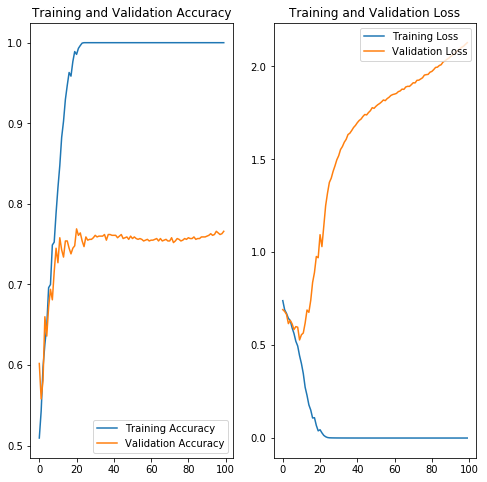

In [102]:
acc = r.history['acc']
val_acc = r.history['val_acc']

loss = r.history['loss']
val_loss = r.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()